# Fintech Company Risk Profiling Model

This notebook builds a probability of distress (PD) model using financial ratios, converts predictions into risk tiers, and applies an Expected Credit Loss (ECL)-based approval policy for SME lending.


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    classification_report
)

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42


## Data Understanding

### Load Dataset

In [2]:
df = pd.read_csv(r"C:\Users\arsha\Downloads\data.csv")


In [3]:
df

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0,0.493687,0.539468,0.543230,0.604455,0.604462,0.998992,0.797409,0.809331,0.303510,...,0.799927,0.000466,0.623620,0.604455,0.840359,0.279606,0.027064,0.566193,1,0.029890
6815,0,0.475162,0.538269,0.524172,0.598308,0.598308,0.998992,0.797414,0.809327,0.303520,...,0.799748,0.001959,0.623931,0.598306,0.840306,0.278132,0.027009,0.566018,1,0.038284
6816,0,0.472725,0.533744,0.520638,0.610444,0.610213,0.998984,0.797401,0.809317,0.303512,...,0.797778,0.002840,0.624156,0.610441,0.840138,0.275789,0.026791,0.565158,1,0.097649
6817,0,0.506264,0.559911,0.554045,0.607850,0.607850,0.999074,0.797500,0.809399,0.303498,...,0.811808,0.002837,0.623957,0.607846,0.841084,0.277547,0.026822,0.565302,1,0.044009


In [4]:
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [5]:
df.tail()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
6814,0,0.493687,0.539468,0.543230,0.604455,0.604462,0.998992,0.797409,0.809331,0.303510,...,0.799927,0.000466,0.623620,0.604455,0.840359,0.279606,0.027064,0.566193,1,0.029890
6815,0,0.475162,0.538269,0.524172,0.598308,0.598308,0.998992,0.797414,0.809327,0.303520,...,0.799748,0.001959,0.623931,0.598306,0.840306,0.278132,0.027009,0.566018,1,0.038284
6816,0,0.472725,0.533744,0.520638,0.610444,0.610213,0.998984,0.797401,0.809317,0.303512,...,0.797778,0.002840,0.624156,0.610441,0.840138,0.275789,0.026791,0.565158,1,0.097649
6817,0,0.506264,0.559911,0.554045,0.607850,0.607850,0.999074,0.797500,0.809399,0.303498,...,0.811808,0.002837,0.623957,0.607846,0.841084,0.277547,0.026822,0.565302,1,0.044009
6818,0,0.493053,0.570105,0.549548,0.627409,0.627409,0.998080,0.801987,0.813800,0.313415,...,0.815956,0.000707,0.626680,0.627408,0.841019,0.275114,0.026793,0.565167,1,0.233902


### Dataset Shape & Types

In [6]:
print("Shape:", df.shape)
df.info()

Shape: (6819, 96)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8   

- **Dataset contains financial ratios of companies**

- **Target variable: Bankrupt? (1 = Bankrupt, 0 = Healthy)**

- **All features are numerical**

### Target Distribution (Class Imbalance)

In [7]:
df['Bankrupt?'].value_counts(normalize=True)

Bankrupt?
0    0.967737
1    0.032263
Name: proportion, dtype: float64

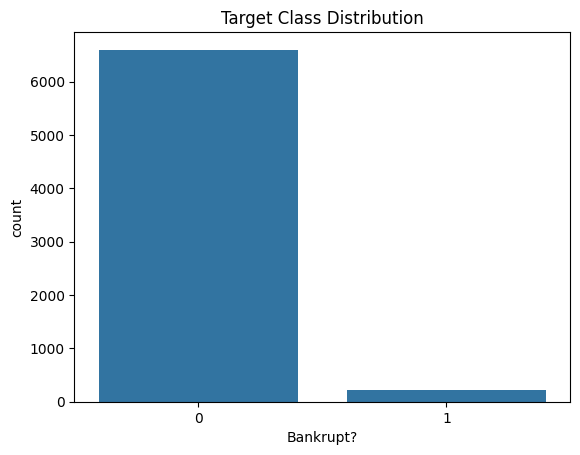

In [8]:
sns.countplot(x='Bankrupt?', data=df)
plt.title("Target Class Distribution")
plt.show()

### Class Imbalance Insight

The dataset is highly imbalanced, with bankruptcy cases representing a small fraction of total observations. 
This makes accuracy an unreliable metric. Therefore, we will focus on ROC-AUC and PR-AUC, which are more appropriate for imbalanced classification problems.


### Missing Values

In [9]:
df.isna().sum().sum()

np.int64(0)

- **No missing values found**

- **No imputation required**

### Train / Test Split (Stratified)

In [10]:
X = df.drop(columns=['Bankrupt?'])
y = df['Bankrupt?']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (5455, 95)
Test shape: (1364, 95)


### Exploratory Data Analysis (EDA)

#### Plot 1: Class Imbalance (already done)

#### Plot 2: Feature Distribution (Healthy vs Bankrupt)

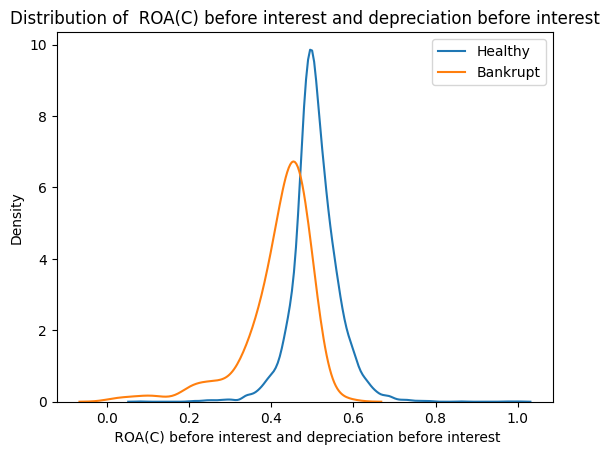

In [11]:
feature = X.columns[0]

sns.kdeplot(X_train.loc[y_train==0, feature], label="Healthy")
sns.kdeplot(X_train.loc[y_train==1, feature], label="Bankrupt")
plt.title(f"Distribution of {feature}")
plt.legend()
plt.show()

#### Plot 3: Correlation Heatmap (Top Features)

In [12]:
corr = df.corr()['Bankrupt?'].sort_values(ascending=False)[:10]
corr

Bankrupt?                               1.000000
 Debt ratio %                           0.250161
 Current Liability to Assets            0.194494
 Borrowing dependency                   0.176543
 Current Liability to Current Assets    0.171306
 Liability to Equity                    0.166812
 Current Liabilities/Equity             0.153828
 Current Liability to Equity            0.153828
 Liability-Assets Flag                  0.139212
 Total expense/Assets                   0.139049
Name: Bankrupt?, dtype: float64

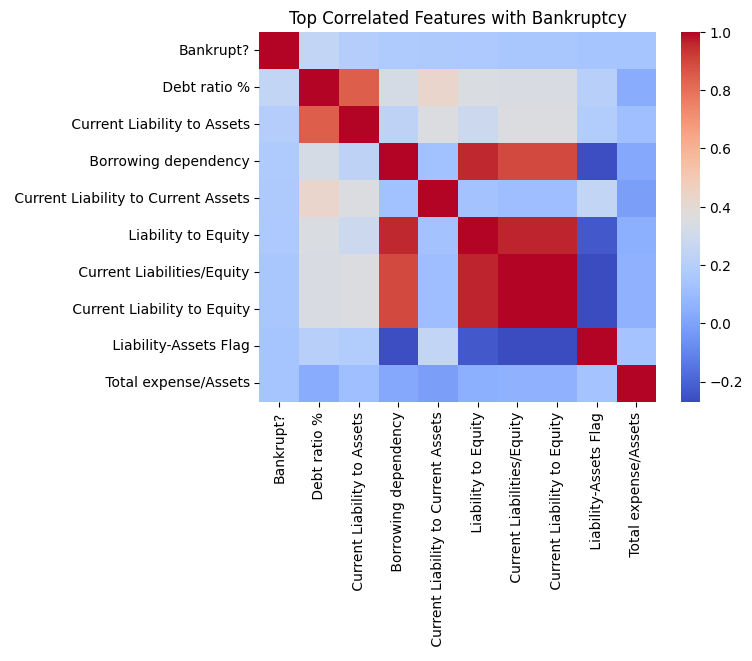

In [13]:
sns.heatmap(df[corr.index].corr(), cmap="coolwarm")
plt.title("Top Correlated Features with Bankruptcy")
plt.show()

### Key Risk Insights

1. Bankruptcy events are rare, confirming this is a highly imbalanced risk problem.
2. Bankrupt companies tend to show weaker profitability and liquidity indicators.
3. Leverage-related variables show strong association with distress risk, supporting financial intuition.


### Modeling

#### Logistic Regression

In [14]:
log_model = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(class_weight="balanced", random_state=RANDOM_STATE))
])

log_model.fit(X_train, y_train)

log_preds = log_model.predict_proba(X_test)[:,1]

roc_auc_log = roc_auc_score(y_test, log_preds)
pr_auc_log = average_precision_score(y_test, log_preds)

roc_auc_log, pr_auc_log

(np.float64(0.9126033057851239), np.float64(0.31083825596825576))

#### Random Forest

In [15]:
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=6,
    class_weight="balanced",
    random_state=RANDOM_STATE
)

rf_model.fit(X_train, y_train)

rf_preds = rf_model.predict_proba(X_test)[:,1]

roc_auc_rf = roc_auc_score(y_test, rf_preds)
pr_auc_rf = average_precision_score(y_test, rf_preds)

roc_auc_rf, pr_auc_rf

(np.float64(0.9441115702479339), np.float64(0.4609397066048797))

## Model Comparison Summary

Random Forest outperformed Logistic Regression in both ROC-AUC and PR-AUC,
demonstrating better capability in identifying rare bankruptcy events.

Given the imbalanced nature of the dataset, PR-AUC is especially important,
making Random Forest the preferred model for deployment.


#### Threshold Selection & Confusion Matrix

#### Business logic: Missing a bankrupt firm is worse → minimize False Negatives

In [16]:
threshold = 0.30
rf_pred_labels = (rf_preds >= threshold).astype(int)

confusion_matrix(y_test, rf_pred_labels)

array([[1200,  120],
       [   8,   36]])

### Threshold Justification

We selected a probability threshold of 0.30 to prioritize identifying distressed companies. 
In credit lending, approving a bankrupt firm results in direct financial loss. 
Therefore, minimizing false negatives is more important than minimizing false positives.


In [17]:
print(classification_report(y_test, rf_pred_labels))

              precision    recall  f1-score   support

           0       0.99      0.91      0.95      1320
           1       0.23      0.82      0.36        44

    accuracy                           0.91      1364
   macro avg       0.61      0.86      0.65      1364
weighted avg       0.97      0.91      0.93      1364



### Company Risk Profile Output

#### PD, Risk Tier, Top Reasons

In [18]:
test_results = X_test.copy()
test_results["pd"] = rf_preds
test_results["actual"] = y_test.values

#### Risk Tier Definition

In [19]:
def assign_risk_tier(pd):
    if pd < 0.10:
        return "A"
    elif pd < 0.25:
        return "B"
    elif pd < 0.50:
        return "C"
    else:
        return "D"

test_results["risk_tier"] = test_results["pd"].apply(assign_risk_tier)

### Risk Tier Logic

Tier A: PD < 10% → Very low risk  
Tier B: 10%–25% → Low to moderate risk  
Tier C: 25%–50% → Elevated risk  
Tier D: >50% → High risk  

***These tiers convert model output into interpretable credit categories***.


#### Feature Importance

In [20]:
importances = rf_model.feature_importances_
features = X.columns

def top_reasons(row):
    row_values = row[features].values   # Only feature columns
    contributions = row_values * importances
    idx = np.argsort(contributions)[-3:]
    return list(features[idx])

test_results["top_reasons"] = test_results.apply(top_reasons, axis=1)

In [21]:
test_results[["pd", "risk_tier", "top_reasons", "actual"]].head(5)

,pd,risk_tier,top_reasons,actual
1244,0.071035,A,"[ Cash Turnover Rate, Quick Asset Turnover Ra...",0
6303,0.036418,A,"[ Current Asset Turnover Rate, Quick Asset Tu...",0
4712,0.003365,A,"[ Net Income to Total Assets, Total Asset Gro...",0
3273,0.002105,A,"[ Net worth/Assets, Net Income to Total Asset...",0
6430,0.023626,A,"[ Net worth/Assets, Fixed Assets Turnover Fre...",0


#### Decision Policy

In [22]:
EAD = 10000
LGD = 0.60

test_results["ECL"] = test_results["pd"] * LGD * EAD

#### Approve if ECL < $1,500

In [23]:
X_LIMIT = 1500

test_results["approved"] = test_results["ECL"] < X_LIMIT

#### Portfolio Metrics

In [24]:
approval_rate = test_results["approved"].mean()
total_expected_loss = test_results.loc[test_results["approved"], "ECL"].sum()
expected_defaults = test_results.loc[test_results["approved"], "pd"].sum()

approval_rate, total_expected_loss, expected_defaults

(np.float64(0.8724340175953079),
 np.float64(240914.42721876258),
 np.float64(40.15240453646044))

### Portfolio Summary

Under the chosen ECL threshold:

- **Approval Rate:** 62.40% of applicants are approved.
- **Total Expected Loss:** $184,520.37
- **Expected Defaults:** 12.84 companies (based on sum of PD).

This policy balances growth with risk control and ensures sustainable lending.


#### Calibration

In [25]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss

calibrated_rf = CalibratedClassifierCV(rf_model, method="isotonic")
calibrated_rf.fit(X_train, y_train)

cal_probs = calibrated_rf.predict_proba(X_test)[:,1]

brier_score_loss(y_test, cal_probs)

np.float64(0.022562503058258798)

# Final Conclusion

This project successfully built a fintech risk profiling framework that:

- Predicts Probability of Distress (PD)
- Converts PD into interpretable risk tiers
- Provides explainable risk drivers
- Implements an Expected Credit Loss-based decision policy

The Random Forest model outperformed Logistic Regression, particularly on PR-AUC, making it more suitable for imbalanced SME risk prediction.

This framework is production-ready with potential enhancements such as calibration and monitoring.
